In [51]:
import os
import re
from Bio import SeqIO
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [61]:
def calc_N50(genomefile):
    contiglens = []
    for record in SeqIO.parse(genomefile, 'fasta'):
        contiglens.append(len(record.seq))
    contiglens = sorted(contiglens, reverse=True)
    gsize = sum(contiglens)
    i, currentsize = 0, 0
    while currentsize <= gsize*0.5:
        currentsize += contiglens[i]
        i += 1
    return contiglens[i]

def calc_busco(buscofile, value):
    buscopat = '\s+C:([\d\.]+)%\[S:([\d\.]+)%,D:([\d\.]+)%\],F:([\d\.]+)%,M:([\d\.]+)%,n:(\d+)'
    with open(buscofile) as infile:
        for line in infile:
            hit = re.search(buscopat, line)
            if hit:
                vals = [float(i) for i in hit.groups()]
                busco = dict(zip(('complete', 
                                  'singleton', 
                                  'duplicate', 
                                  'failed', 
                                  'missing', 
                                  'n'), 
                                 vals))
                break
    return busco[value]
                

In [62]:
buscos = []
for species in genomes.keys():
    for file in os.listdir(f'../data/busco-out/{species}'):
        buscofile = f'../data/busco-out/{species}/{file}'
        buscos.append((species, 
                       calc_busco(buscofile, 'complete')))
busco_df = pd.DataFrame(buscos, columns=['species', 'busco_complete'])

In [ ]:
with open('../data/species_genomes.txt') as infile:
    genomes = {line.split()[0]: f'/Users/jonwells/Genomes/Cypriniformes/ncbi-genomes-2020-07-09/{line.split()[1]}' for line in infile}

n50s = []
for species, genomefile in genomes.items():
    n50s.append((species, calc_N50(genomefile)))
n50_df = pd.DataFrame(n50s, columns=['species', 'N50'])

In [63]:
qc_df = pd.merge(n50_df, busco_df, on='species')
print(qc_df.sort_values('busco_complete'))

                         species       N50  busco_complete
13                  Labeo_gonius      3580            26.0
10         Cirrhinus_molitorella      4199            34.8
14    Poropuntius_huangchuchieni      2931            36.9
1            Pimephales_promelas     60365            71.8
30                 Danio_choprai   5574156            72.7
23            Leuciscus_waleckii  21776898            74.0
24       Paedocypris_carbunculus     59221            77.7
28            Danio_albolineatus   4543946            78.4
25     Paedocypris_micromegethes     61829            79.9
33                 Danio_tinwini  13167244            81.1
2                Cyprinus_carpio   7653411            82.0
15    Hypophthalmichthys_nobilis     83001            83.6
29           Danio_jaintianensis  17381796            86.6
16   Hypophthalmichthys_molitrix    314070            86.9
26            Danionella_dracula   9915436            89.9
27        Danionella_translucida   5368897            90

1            Pimephales_promelas
10         Cirrhinus_molitorella
13                  Labeo_gonius
14    Poropuntius_huangchuchieni
15    Hypophthalmichthys_nobilis
24       Paedocypris_carbunculus
25     Paedocypris_micromegethes
Name: species, dtype: object


[]

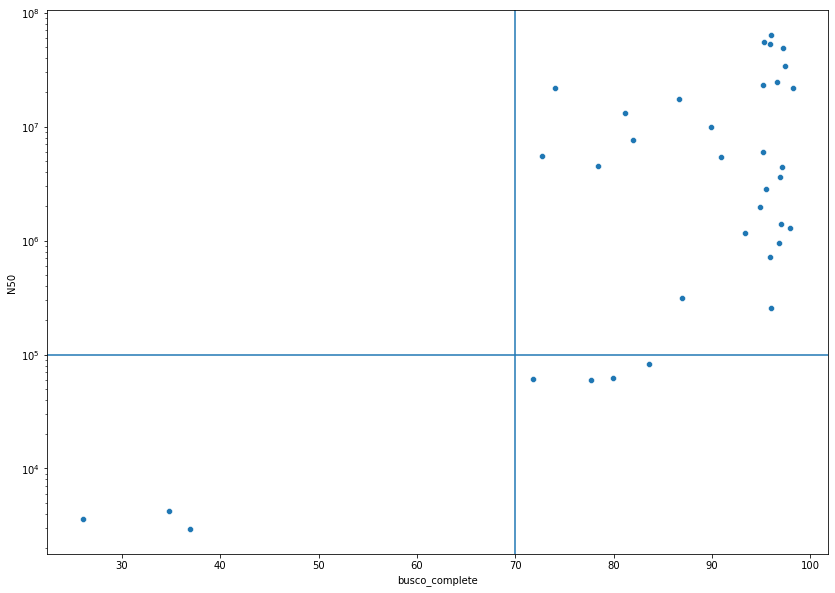

In [81]:
print(qc_df.loc[(qc_df.N50 < 1e05) | (qc_df.busco_complete < 70)].species)
fig, ax = plt.subplots(figsize=(14, 10))
sns.scatterplot(data=qc_df, x='busco_complete', y='N50')
ax.set_yscale('log')
ax.axvline(x=70)
ax.axhline(y=1e05)
plt.plot()

In [80]:
p = 1
for i in qc_df.loc[(qc_df.N50 > 1e05) & (qc_df.busco_complete > 70) ,'busco_complete']:
    p *= i/100
print(p)
print(p*3300)

0.08293970287785085
273.7010194969078
